In [2]:
from numpy.random import normal,multivariate_normal
import numpy as np
from numpy.linalg import inv
from numpy import genfromtxt

from scipy import *
from scipy.linalg import norm, pinv, det
from scipy.optimize import minimize

import csv

import cvxopt as opt
from cvxopt import matrix, solvers


import matplotlib.pyplot as plt
import matplotlib.colors as colors
#import numdifftools as nd

from PIL import Image
import matplotlib.image as mping

import pandas as pd
from __future__ import division


In [3]:
#Read the data 
Xtr = genfromtxt('Xtr.csv', delimiter = ',')
d = Xtr.shape[1]

Xtr = np.delete(Xtr, (d-1), axis = 1)

Ytr = pd.read_csv('Ytr.csv')
Ytr = np.array(Ytr)
Ytr = np.delete(Ytr, (0), axis = 1)

n = Xtr.shape[0]
d = Xtr.shape[1]

#Xtr is a 5000 * 3072 dimensional matrix

#Ytr is a 5000*1 dimensional matrix



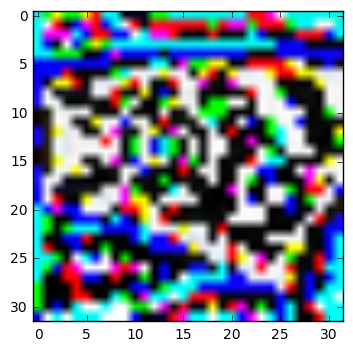

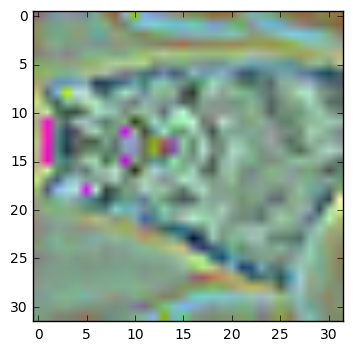

In [14]:
#The block to display images

def displayImage(image):
    plt.imshow(image)#, cmap='Greys')
    plt.show()

Im = Xtr[35]

Xtilde = np.reshape(Xtr, (5000, 3, 1024))

minR = np.min(Xtilde[:,0,:])
minG = np.min(Xtilde[:,1,:])
minB = np.min(Xtilde[:,2,:])

maxR = np.max(Xtilde[:,0,:])
maxG = np.max(Xtilde[:,1,:])
maxB = np.max(Xtilde[:,2,:])

Im = np.reshape(Im, (3,1024))

Rmax = amax(Im[0,:])
Rmin = amin(Im[0,:])
    
Gmax = amax(Im[1,:])
Gmin = amin(Im[1,:])

Bmax = amax(Im[2,:])
Bmin = amin(Im[2,:])
I = np.zeros((3,Im.shape[1]))
I[0,:] = (Im[0,:]-Rmin)/(Rmax-Rmin)
I[1,:] = (Im[1,:]-Rmin)/(Gmax-Gmin)
I[2,:] = (Im[2,:]-Rmin)/(Bmax-Bmin)



I = np.reshape(I,(3,32,32))
Im = np.reshape(Im, (3,32,32))
#I = (0.21*Im[0,:,:]+0.72*Im[1,:,:]+ 0.07*Im[2,:,:])
I = I.T

Im= Im.T

displayImage(Im)
displayImage(I)





In [22]:
#Preprocessing images
#Code to tranform images into 16*16*16 dimensional histograms

#This function enforces the number C to be equal to 16 if C is greater than 16
def maxInt(NbBins, C):
    if C > NbBins-1:
        return NbBins-1
    else:
        return C


#Here we quantize the image

def quantize(Image, nbBins):
    
    #Image is a 3*1024 dimensional matrix
    
    Rmax = amax(Image[0,:])
    Rmin = amin(Image[0,:])
    
    Gmax = amax(Image[1,:])
    Gmin = amin(Image[1,:])

    Bmax = amax(Image[2,:])
    Bmin = amin(Image[2,:])
    
    #Range of all chanel RGB
    Rrange = Rmax-Rmin
    Grange = Gmax-Gmin
    Brange = Bmax-Bmin
    
    #We want 16 intervals for each colour
    qR = float(Rrange)/nbBins
    qG = float(Grange)/nbBins
    qB = float(Brange)/nbBins
    
    
    I= np.zeros((3,1024))
    histogram = np.zeros((nbBins,nbBins,nbBins))
    #I= np.zeros((32,32,3))
    for pixel in range(1024):
        #r,g, and b respectively represent the bin number to which pixel belongs
        r = ceil(float(Im[0,pixel]-Rmin)/qR)
        g = ceil(float(Im[1,pixel]-Gmin)/qG)
        b = ceil(float(Im[2,pixel]-Bmin)/qB)
            
        #We assign new value for the new image I
        I[0,pixel] = r*qR + float(qR)/2 + Rmin
        I[1,pixel] = g*qG + float(qG)/2 + Gmin
        I[2,pixel] = b*qB + float(qB)/2 + Bmin
            
        #I[i,j,0] = ceil(float(Im[i,j,0]-Rmin)/qR)*qR + float(qR)/2 + Rmin
        #I[i,j,1] = ceil(float(Im[i,j,1]-Gmin)/qG)*qG + float(qG)/2 + Gmin
        #I[i,j,2] = ceil(float(Im[i,j,2]-Bmin)/qB)*qB + float(qB)/2 + Bmin
            
        #The histogram is updated by adding 1 to the new corresponding bin
        histogram[maxInt(nbBins,r), 
                  maxInt(nbBins,g), 
                  maxInt(nbBins,b)]+=1
            
    I =np.reshape(I, 3072)
    histogram = np.reshape(histogram, nbBins**3)
    return I,histogram

def center_image(Im):
     #Image is a 3*1024 dimensional matrix
    
    Rmax = amax(Im[0,:])
    Rmin = amin(Im[0,:])
    
    Gmax = amax(Im[1,:])
    Gmin = amin(Im[1,:])

    Bmax = amax(Im[2,:])
    Bmin = amin(Im[2,:])
    I = np.zeros((3,Im.shape[1]))
    I[0,:] = (Im[0,:]-Rmin)/(Rmax-Rmin)
    I[1,:] = (Im[1,:]-Rmin)/(Gmax-Gmin)
    I[2,:] = (Im[2,:]-Rmin)/(Bmax-Bmin)
    return I



def Compute_Histogram(Image, nbBins):
    Image = center_image(Im)
    R = Image[0,:]
    G = Image[1,:]
    B = Image[2,:]
    
    #LR = np.linspace(minR, maxR, nbBins)
    #LG = np.linspace(minG, maxG, nbBins)
    #LB = np.linspace(minB, maxB, nbBins)
    LR = np.linspace(0, 1, nbBins)
    LG = np.linspace(0, 1, nbBins)
    LB = np.linspace(0, 1, nbBins)
    
    
    h = np.zeros((nbBins,nbBins,nbBins))
    
    nbpixel = 0
    for i in range(nbBins-1):
        for j in range(nbBins-1):
            for k in range(nbBins-1):
                h[i,j,k] = (np.where((R>=LR[i]) & (R < LR[i+1]) & (G>=LG[j]) & (G < LG[j+1]) &(B>=LB[k]) & (B < LB[k+1]))[0]).shape[0]
                nbpixel += h[i,j,k] 
                #h[i,j,k] = (np.where((G>=LG[k]) & (G < LG[k+1]))[0]).shape[0]
                #h[i,j,k] = (np.where((B>=LB[k]) & (B < LB[k+1]))[0]).shape[0]
    h = h/(R.shape[0])
    h = np.reshape(h, nbBins**3)
    return h


In [23]:
#In this block we fill the new images (encoded with 16 bins) and the histograms
nbBins = 16
X = np.zeros((Xtr.shape[0], 3072))

Histogram = np.zeros((Xtr.shape[0], nbBins**3))
#Histograms is a 5000 * 16 * 16 * 16 dimensional matrix
X = np.zeros((Xtr.shape[0], 1024))

for i in range(Xtr.shape[0]):
    print i
    Im = Xtr[i]
    Im = np.reshape(Im,(3,1024))
    #I = center_image(Im)
    #I = np.reshape(I, (3, 32, 32))
    #I = colors.rgb_to_hsv(I.T)
    #I = I.T
    #I= np.reshape(I, (3,1024))
    I = (0.31*Im[0,:]+0.59*Im[1,:]+ 0.10*Im[2,:])
    #X[i,:], Histogram[i,:] = quantize(Im, nbBins)
    
    Histogram[i,:] = Compute_Histogram(Im, nbBins)
    
    X[i,:] = I


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [24]:
#In this block, we draw a sample of the data for one versus all and k-cross validation
P = 5
rho =1

#Compute a distance for histograms
def distance(x,y):
    index = np.where((x != 0) | (y != 0))[0]
    d = np.sum((x[index]-y[index])**2/(x[index]+y[index]))
    return d

def Linear_Kernel(x,y):
    #return 0.12*(np.dot(x,y))+1.05*(np.dot(x,y))**2 + 0.012 * (np.dot(x,y))**3 
    return exp(-rho * np.dot(x-y,x-y))
    #return exp(-rho * distance(x,y))
    #return  (np.dot(x,y))**2

    
    
def KernelComputation(x):
    K = np.zeros((x.shape[0],x.shape[0]))
    for line in range(x.shape[0]):
        print line
        for col in range(x.shape[0]):
            if (line<=col):
                value= Linear_Kernel(x[line,:],x[col,:])
                K[col,line]=value
                K[line,col]=value
    return K


    
#K = KernelComputation(X)
K = KernelComputation(Histogram)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
#I mmodified a bit th linear kernel to test the efficiency of a polynomial kernel. 
#Clearly we should better use a polynomial kernel with a degree greater or equal than 2


#Return x (images) and y corresponding to label1 and label2 
def Fill_x_y_label(X, label1,label2):
    
    #x1=X[np.where(Ytr==label1)[0],:]
    #x2=X[np.where(Ytr==label2)[0],:]
    x1=X[np.where(Ytr==label1)[0],:]
    x2=X[np.where(Ytr==label2)[0],:]
    x=np.concatenate([x1,x2])
    
    
    y1=np.ones(x1.shape[0])
    y2=-1*np.ones(x2.shape[0])
    y=np.concatenate([y1,y2])
    return x,y;

In [26]:
#Cross-validation procedure
NbTrain =400
#NbTrain is a number of training data labeled by 1 I extract from the initial dataset
#NbTrain =400 in our case. I consider 400 data points of label 1 in tmy training set

def Fill_Training_Test_Set(X, label1, label2, Kernel):
    NbTest = 500-NbTrain
    
    x, y = Fill_x_y_label(X,label1,label2)
    
    yTrain = np.concatenate([np.ones(NbTrain), -np.ones(NbTrain)])
    xTrain = np.concatenate([x[0:NbTrain,:],x[500: 500 + NbTrain,:]])
    yTest = np.concatenate([np.ones(NbTest),-np.ones(NbTest)])
    xTest = np.concatenate([x[NbTrain:500,:],x[500 + NbTrain: 1000,:]])
    
    index  = np.concatenate([np.where(Ytr==label1)[0][0:NbTrain], np.where(Ytr==label2)[0][0:NbTrain]])
    KTrain= Kernel[index,:]
    KTrain = KTrain[:,index]
    return xTrain,yTrain, xTest, yTest,KTrain



In [27]:
#Optimization model
def Training_model(y, Kernel, Lambda):
    P = matrix(2*Kernel)
    q = matrix(-2*y)
    G = matrix(np.concatenate(((-1)*np.diag(y),np.diag(y))), tc='d')
    h = matrix(np.concatenate([np.zeros(y.shape), (1/(2*float(Lambda*y.shape[0])))*np.ones(y.shape)]), tc='d')
    A = matrix(np.ones(y.shape), (1, y.shape[0]))
    #A = matrix(np.ones(1,y.shape[0]),(1,y.shape[0]))
    b = matrix(0.0)
    sol = solvers.qp(P,q,G,h)#A,b)
    alpha = sol['x']
    print sol['status']
    alpha = np.array(alpha)
    return alpha


#Compute the new obtained label
def SVM_function(alpha, xtrain ,x_querry):
    value = 0
    for i in range(alpha.shape[0]):
        Current_Image=xtrain[i,:]
        value += alpha[i]*Linear_Kernel(x_querry,Current_Image)
    return value


In [33]:
#Block to perform the optimization with the linear kernel

#Just a test for the one vs one classifier 
Lambda=0.001
NbLabel =10
NbTest = 2*(500-NbTrain)


xTrain, yTrain, xTest, yTest ,KTrain = Fill_Training_Test_Set(Histogram, 1, 2, K)
alpha  = Training_model(yTrain, KTrain, Lambda)


error =0
for i in range(NbTest):
    Label_found = sign(SVM_function(alpha, xTrain, xTest[i,:]))
    #print SVM_function(alpha, xTrain, xTest[i,:])
    if(Label_found != yTest[i]):
        error += 1
Accuracy = (1-(error)/NbTest)*100.0
print 'Accuracy :', Accuracy, '%'
        

AccuracyMin  = 100
labelMin1 = 0
labelMin2 = 0

WorstDuels = np.ones((NbLabel,NbLabel))

Threshold = 60

N = 2*NbTrain
NbLabel = 10


AlphaClassifiers = np.zeros((NbLabel,NbLabel,N))


#The following block tests all duels between labels
for label1 in range(NbLabel):
    for label2 in range(NbLabel):
        if(label2 > label1):
            xTrain, yTrain, xTest, yTest ,KTrain = Fill_Training_Test_Set(Histogram, label1, label2, K)
            alpha  = Training_model(yTrain, KTrain, Lambda)
            AlphaClassifiers[label1, label2, :] = alpha[:,0]
            error = 0
            for i in range(NbTest):
                Label_found = sign(SVM_function(alpha, xTrain, xTest[i,:]))
                if(Label_found != yTest[i]):
                    error += 1
            Accuracy = (1-(error)/NbTest)*100.0
            print 'Accuracy :', Accuracy, '%'
            if(Accuracy < Threshold):
                WorstDuels[label1, label2] = 0
            if(AccuracyMin > Accuracy):
                AccuracyMin = Accuracy
                labelMin1 = label1
                labelMin2 = label2

     pcost       dcost       gap    pres   dres
 0: -1.9187e+03 -1.7313e+03  8e+03  5e+00  1e-13
 1: -8.2397e+02 -1.5044e+03  7e+02  7e-16  1e-13
 2: -9.2969e+02 -9.8003e+02  5e+01  2e-16  8e-14
 3: -9.4491e+02 -9.6891e+02  2e+01  2e-16  8e-14
 4: -9.4951e+02 -9.6516e+02  2e+01  2e-16  7e-14
 5: -9.5394e+02 -9.6122e+02  7e+00  2e-16  7e-14
 6: -9.5683e+02 -9.5882e+02  2e+00  2e-16  9e-14
 7: -9.5761e+02 -9.5799e+02  4e-01  2e-16  9e-14
 8: -9.5779e+02 -9.5781e+02  1e-02  2e-16  9e-14
 9: -9.5780e+02 -9.5780e+02  1e-04  2e-16  9e-14
Optimal solution found.
optimal
Accuracy : 55.5 %
     pcost       dcost       gap    pres   dres
 0: -1.8647e+03 -1.8836e+03  1e+04  6e+00  2e-13
 1: -7.8286e+02 -1.6332e+03  9e+02  8e-16  1e-13
 2: -8.8846e+02 -9.8013e+02  9e+01  2e-16  7e-14
 3: -9.0661e+02 -9.4242e+02  4e+01  2e-16  7e-14
 4: -9.0932e+02 -9.3738e+02  3e+01  2e-16  7e-14
 5: -9.1454e+02 -9.2842e+02  1e+01  2e-16  7e-14
 6: -9.1761e+02 -9.2395e+02  6e+00  2e-16  7e-14
 7: -9.1924e+02 -9.21

KeyboardInterrupt: 

In [29]:
def ToTal_set(X):
    xtest =np.zeros((1,X.shape[1]))
    ytest = np.zeros((1,1))
    xtrain = np.zeros((NbLabel,NbTrain,X.shape[1]))
    for label in range(NbLabel):
        x1=X[np.where(Ytr==label)[0],:]
        xtrain[label,:,:] = x1[0: NbTrain,:]
        xtest=np.concatenate([xtest,x1[NbTrain: 500,:]])
    
        y1 = label * np.ones((500 - NbTrain, 1))
        ytest=np.concatenate([ytest,y1])
    xtest = np.delete(xtest, 0, 0)
    ytest = np.delete(ytest, 0, 0)
    return xtrain, xtest, ytest


    
def FindLabels(xtrain, Image):
    delta = np.zeros((NbLabel,1))
    for label1 in range(NbLabel):
        for label2 in range(NbLabel):
            if(label2 > label1):
                current_training_set = np.concatenate([xtrain[label1,:,:],xtrain[label2,:,:]])
                value = SVM_function(AlphaClassifiers[label1,label2,:], current_training_set, Image)
                if value > 0:
                    delta[label1,0] += WorstDuels[label1, label2]
                    #delta[label2,0] -= 1
                if value < 0:
                    #delta[label1,0] -= 1
                    delta[label2,0] += WorstDuels[label1, label2]
                    
    labelFound = argmax(delta[:,0])
    return labelFound

NbTest = NbLabel*(500-NbTrain)

xtrain, xtest, ytest = ToTal_set(Histogram)
print xtest.shape

error =0


for i in range(NbTest):
    label_found = FindLabels(xtrain, xtest[i,:])
    if(label_found != ytest[i]):
        error = error +1
    Accuracy = (1-(float(error)/(i+1)))*100.0
    print 'Accuracy :', Accuracy, '%'

                
            

(1000L, 4096L)
Accuracy : 0.0 %
Accuracy : 0.0 %
Accuracy : 33.3333333333 %
Accuracy : 25.0 %
Accuracy : 40.0 %
Accuracy : 33.3333333333 %
Accuracy : 28.5714285714 %
Accuracy : 25.0 %
Accuracy : 22.2222222222 %
Accuracy : 20.0 %
Accuracy : 27.2727272727 %
Accuracy : 33.3333333333 %
Accuracy : 38.4615384615 %
Accuracy : 35.7142857143 %
Accuracy : 33.3333333333 %
Accuracy : 31.25 %
Accuracy : 29.4117647059 %
Accuracy : 27.7777777778 %
Accuracy : 26.3157894737 %
Accuracy : 25.0 %
Accuracy : 23.8095238095 %
Accuracy : 22.7272727273 %
Accuracy : 21.7391304348 %
Accuracy : 25.0 %
Accuracy : 24.0 %
Accuracy : 23.0769230769 %
Accuracy : 22.2222222222 %
Accuracy : 21.4285714286 %
Accuracy : 20.6896551724 %
Accuracy : 20.0 %
Accuracy : 22.5806451613 %
Accuracy : 21.875 %


KeyboardInterrupt: 

In [ ]:
with open('test.csv', 'wb') as f:
    writer = csv.writer(f)
    for val in Test:
        writer.writerow([val])